In [ ]:
!pip freeze | grep optuna

In [2]:
!pip install optuna -q

In [3]:
!pip freeze | grep optuna

optuna==3.0.5


In [ ]:
!pip freeze | grep catboost

In [5]:
!pip install catboost -q

In [6]:
!pip freeze | grep catboost

catboost==1.1.1


In [7]:
import os

import numpy as np
import pandas as pd
import copy 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

import catboost as cb
import optuna

from tqdm import tqdm_notebook
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

In [8]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
N_FOLDS = 5

In [9]:
np.random.seed(RANDOM_STATE)

Input variables:

> bank client data:
* 1 - age (numeric)
* 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* 5 - default: has credit in default? (categorical: 'no','yes','unknown')
* 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
* 7 - loan: has personal loan? (categorical: 'no','yes','unknown')

> related with the last contact of the current campaign:
* 8 - contact: contact communication type (categorical: 'cellular','telephone') 
* 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* 11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

> other attributes:
* 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* 14 - previous: number of contacts performed before this campaign and for this client (numeric)
* 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

> social and economic context attributes
* 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
* 17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
* 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
* 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
* 20 - nr.employed: number of employees - quarterly indicator (numeric)

> Output variable (desired target):
* 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [10]:
df = pd.read_csv('/content/bank_marketing.csv')

In [26]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.100,93.994,-36.400,4.857,5191.000,0


In [12]:
df.shape

(41188, 21)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [14]:
df['y'] = np.where(df['y']=='yes', 1, 0)

In [15]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.000,41188.000,41188.000,41188.000,41188.000,41188.000,41188.000,41188.000,41188.000,41188.000,41188.000
mean,40.024,258.285,2.568,962.475,0.173,0.082,93.576,-40.503,3.621,5167.036,0.113
std,10.421,259.279,2.770,186.911,0.495,1.571,0.579,4.628,1.734,72.252,0.316
min,17.000,0.000,1.000,0.000,0.000,-3.400,92.201,-50.800,0.634,4963.600,0.000
25%,32.000,102.000,1.000,999.000,0.000,-1.800,93.075,-42.700,1.344,5099.100,0.000
50%,38.000,180.000,2.000,999.000,0.000,1.100,93.749,-41.800,4.857,5191.000,0.000
75%,47.000,319.000,3.000,999.000,0.000,1.400,93.994,-36.400,4.961,5228.100,0.000
max,98.000,4918.000,56.000,999.000,7.000,1.400,94.767,-26.900,5.045,5228.100,1.000


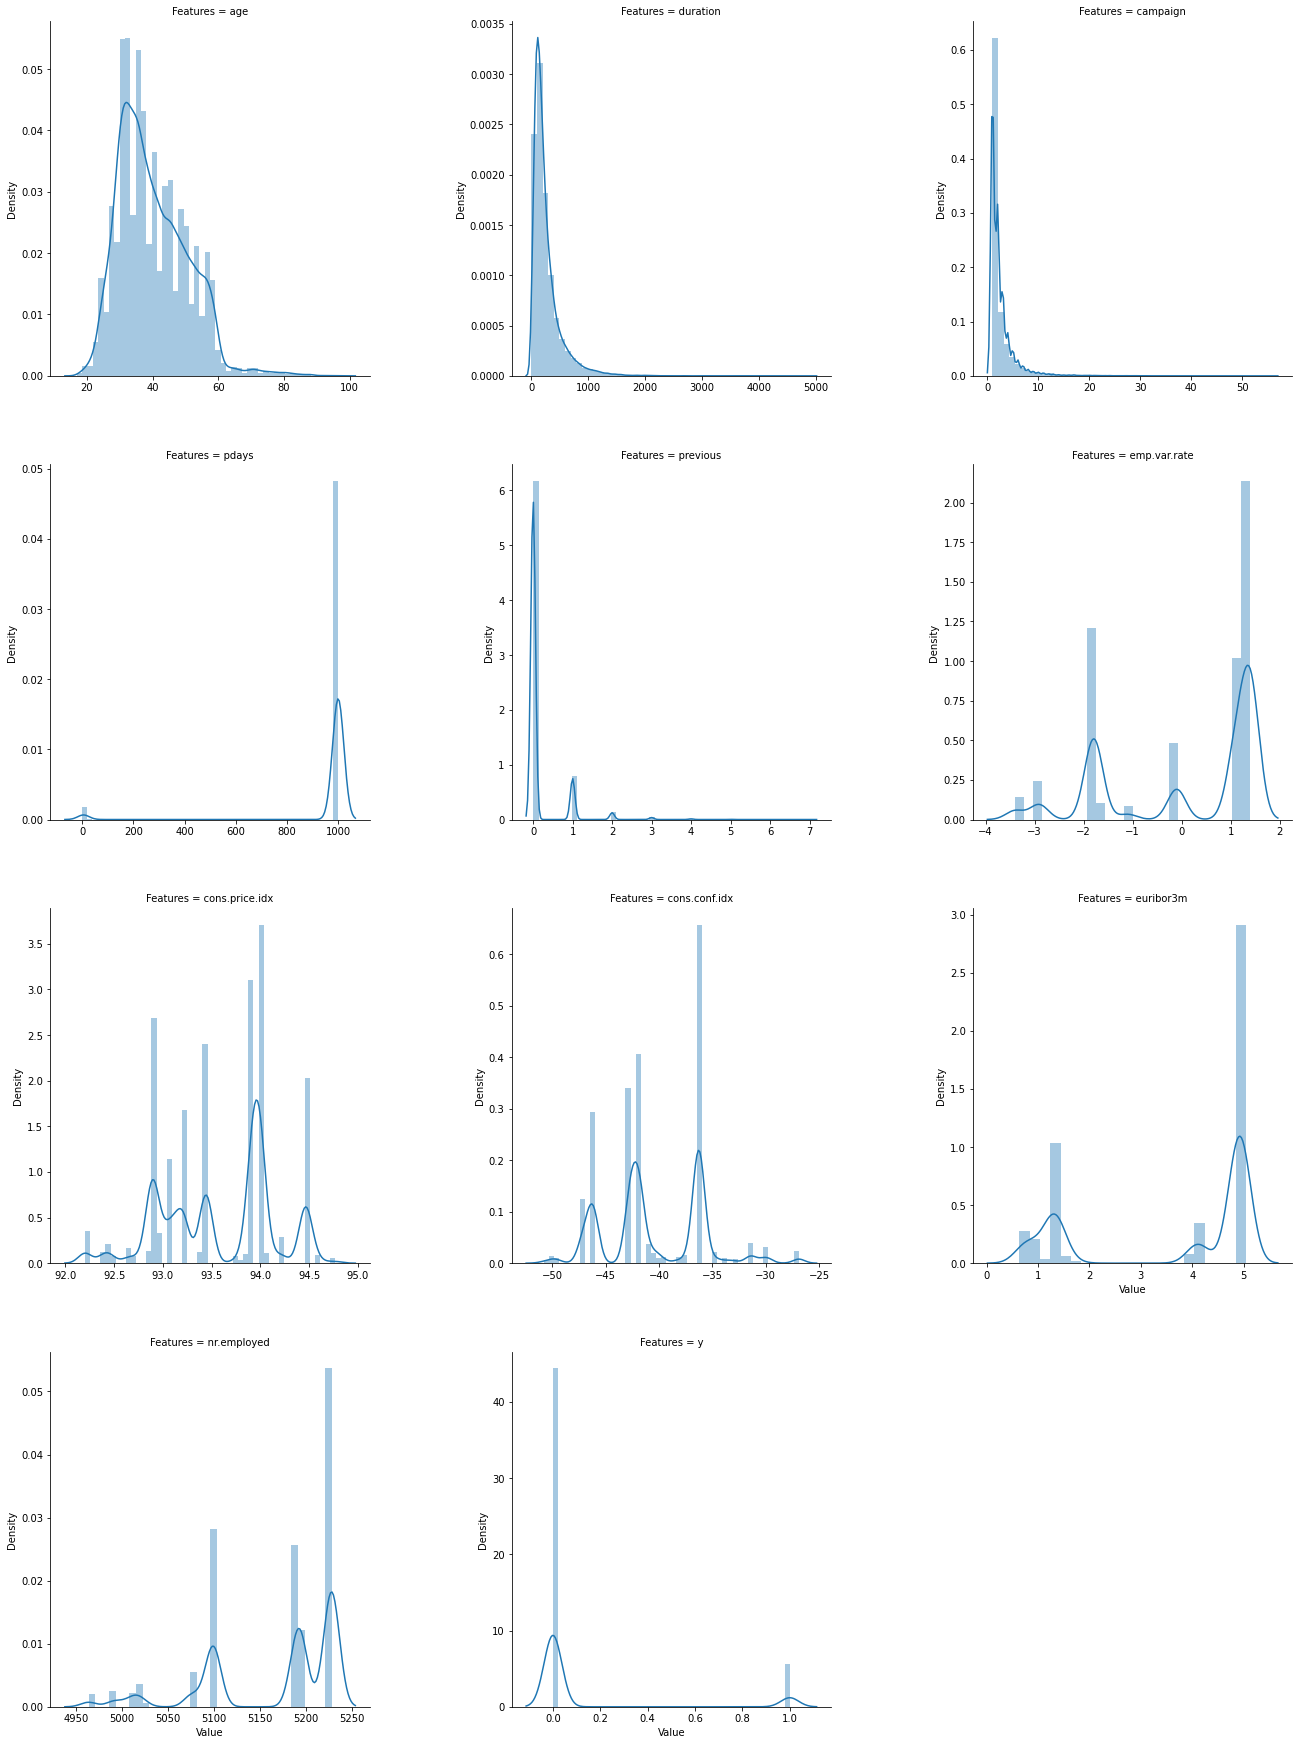

In [16]:
num_cols = df.select_dtypes(include=[np.float64,np.int64]).columns
numeric_features = df[num_cols]
numeric_features = numeric_features.stack().reset_index().rename(
    columns={'level_1': 'Features', 0: 'Value'})

ax = sns.FacetGrid(data=numeric_features, col='Features',
                   col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, 'Value')

plt.subplots_adjust(top=2, right=2)

In [17]:
df_log = copy.deepcopy(df)

In [18]:
for i in num_cols:
    df_log[i] = np.log(df_log[i]+1)

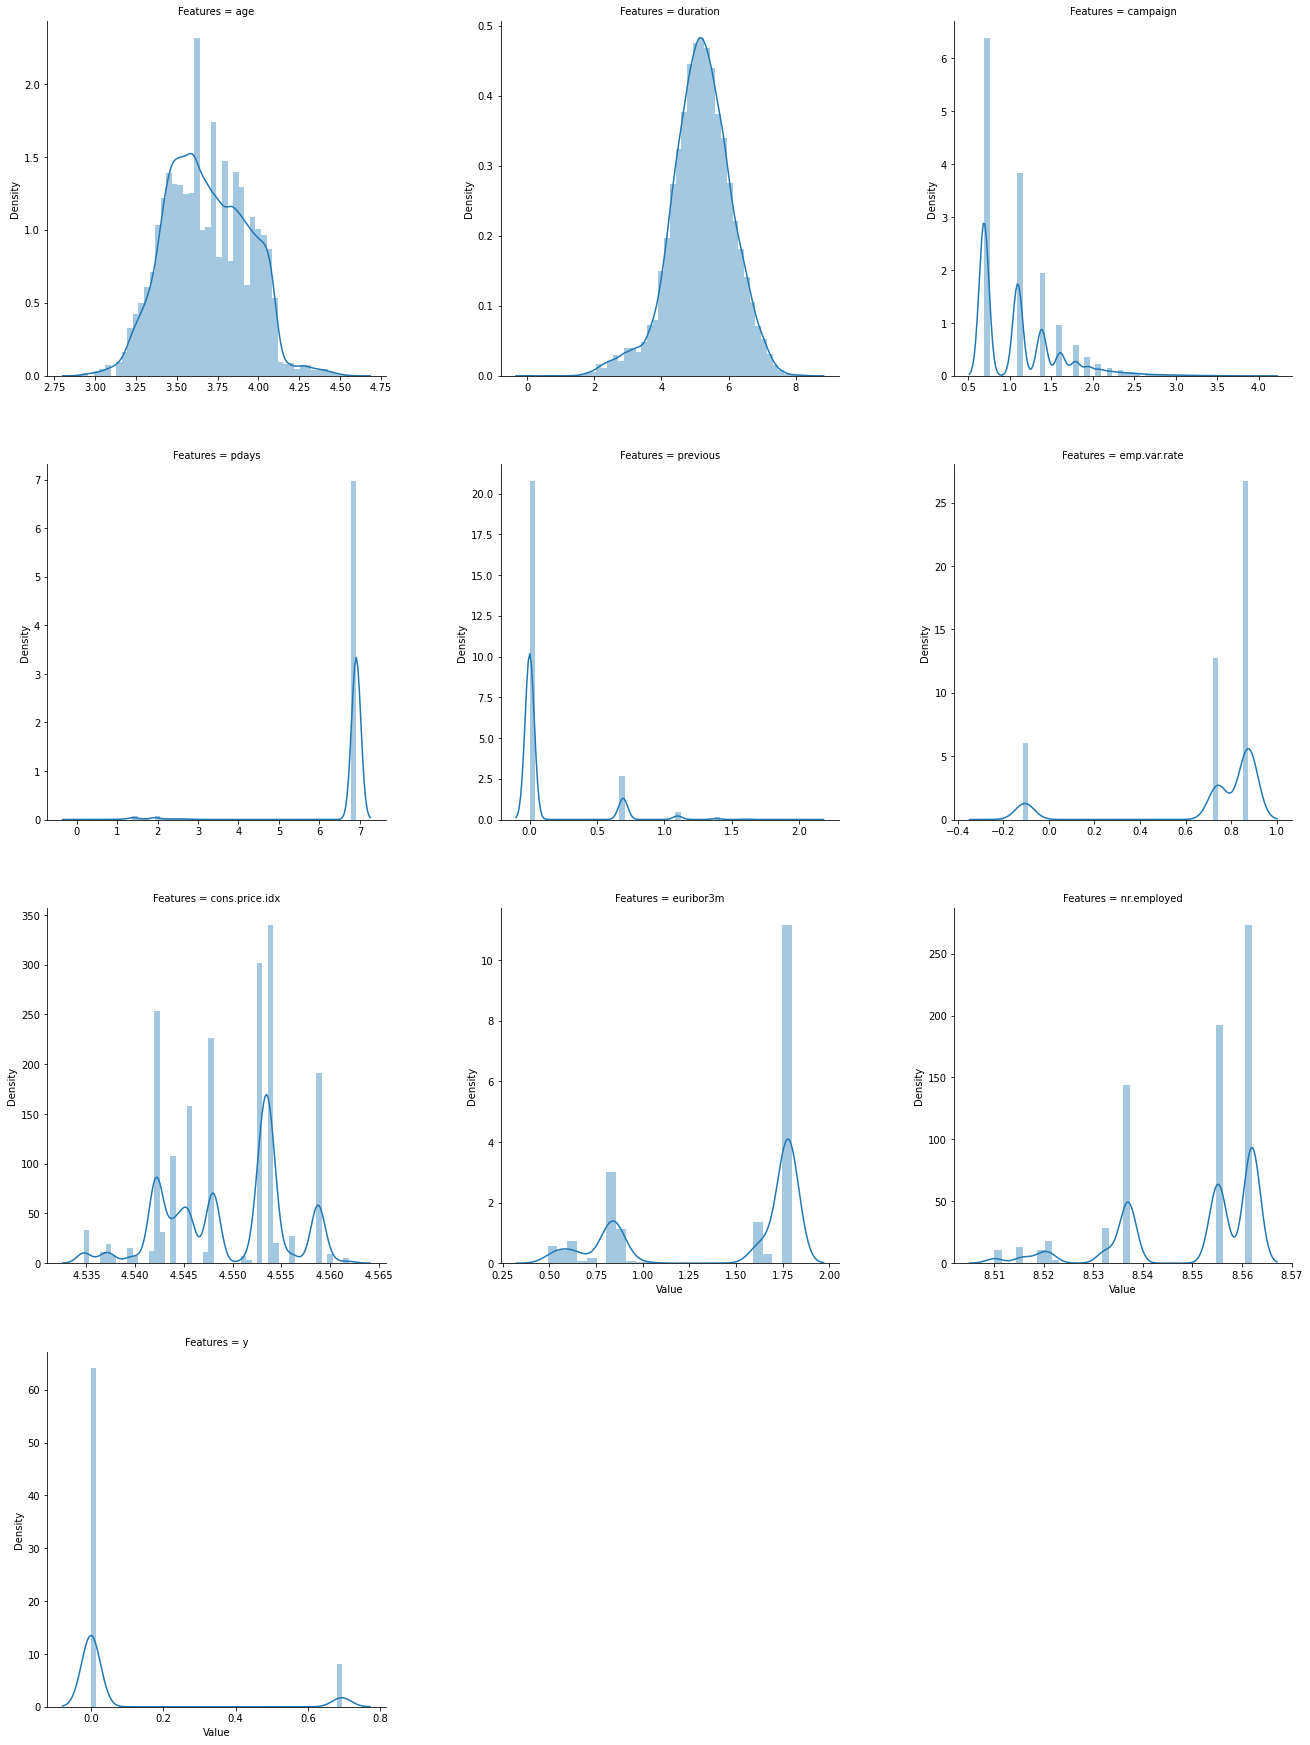

In [19]:
numeric_features = df_log[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(columns={
    'level_1': 'Features',
    0: 'Value'
})

ax = sns.FacetGrid(data=numeric_features,
                   col='Features',
                   col_wrap=3,
                   sharex=False,
                   sharey=False)
ax = ax.map(sns.distplot, 'Value')

plt.subplots_adjust(top=2, right=2)

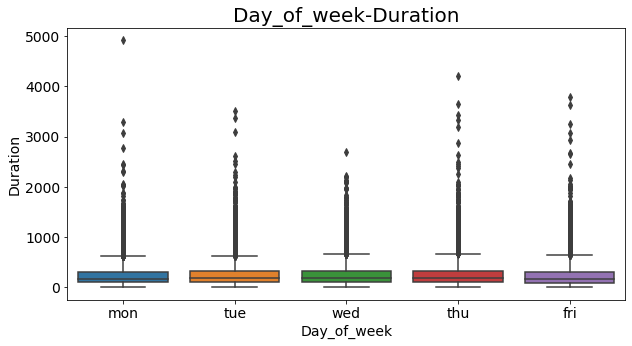

In [20]:
plt.figure(figsize=(10, 5))

sns.boxplot(x='day_of_week', y='duration', data=df)

plt.title('Day_of_week-Duration', fontsize=20)
plt.ylabel('Duration', fontsize=14)
plt.xlabel('Day_of_week', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

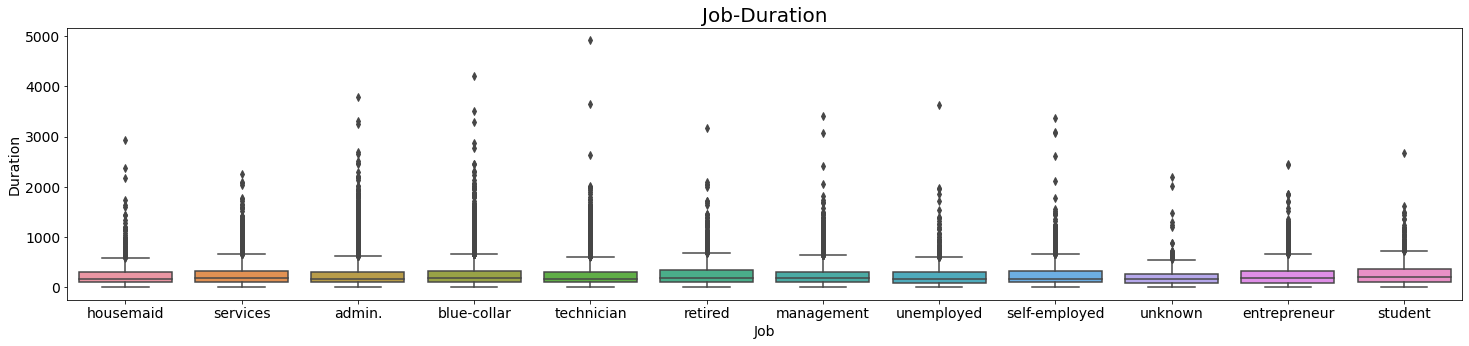

In [21]:
plt.figure(figsize=(25, 5))

sns.boxplot(x='job', y='duration', data=df)

plt.title('Job-Duration', fontsize=20)
plt.ylabel('Duration', fontsize=14)
plt.xlabel('Job', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

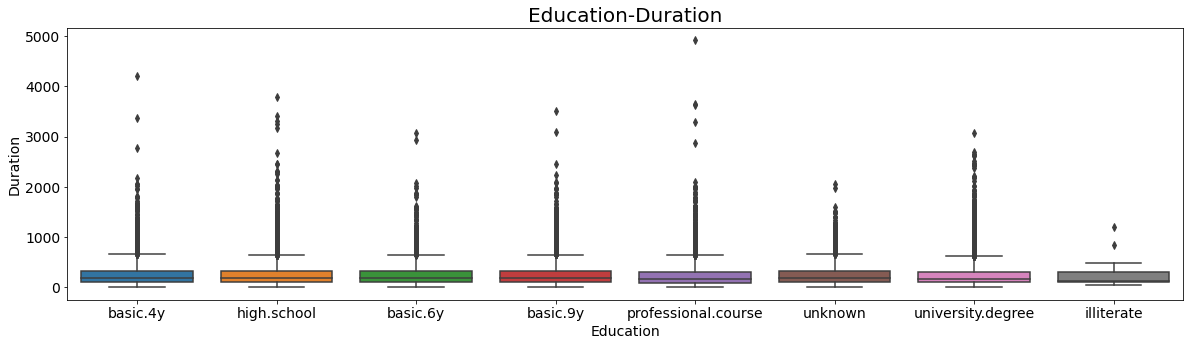

In [22]:
plt.figure(figsize=(20, 5))

sns.boxplot(x='education', y='duration', data=df)

plt.title('Education-Duration', fontsize=20)
plt.ylabel('Duration', fontsize=14)
plt.xlabel('Education', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

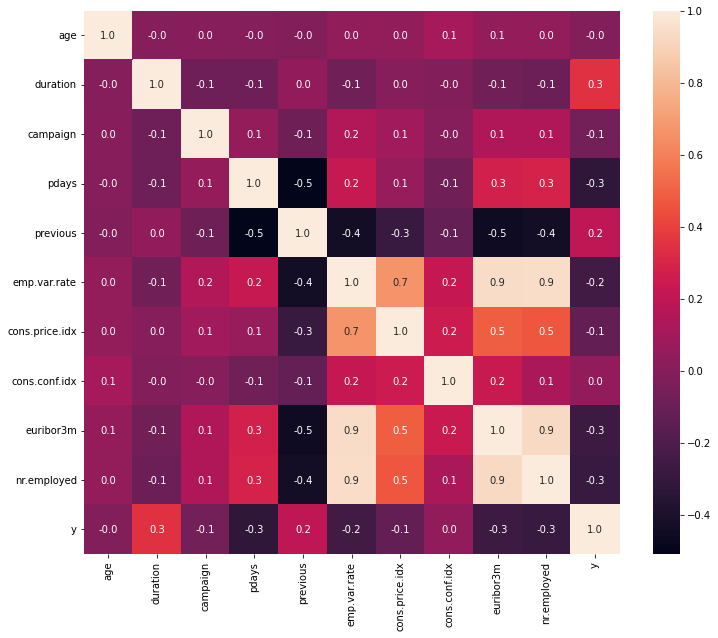

In [23]:
plt.figure(figsize=(12, 10))

sns.heatmap(df.corr(method='spearman'), annot=True, fmt='.1f');

In [24]:
def objective(trial):
    X = df.drop(columns=['y'], axis=1)
    y = df[['y']]
 
    categorical_features_indices = np.where( (X.dtypes!=np.float) & (X.dtypes != np.int))[0]

    x_train, x_valid, y_train, y_valid = train_test_split(X, 
                                                          y, 
                                                          test_size=TEST_SIZE,
                                                          random_state=RANDOM_STATE)
  
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    model = cb.CatBoostClassifier(**param)
    model.fit(x_train,
              y_train,
              eval_set=[(x_valid, y_valid)],
              cat_features = categorical_features_indices, 
              verbose=0,
              early_stopping_rounds=100)
    preds = model.predict(x_valid)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_valid, pred_labels)
    return accuracy

In [25]:
study = optuna.create_study(direction='maximize', study_name='CatBoost')
study.optimize(objective, n_trials=5, timeout=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-31 15:31:55,280] A new study created in memory with name: CatBoost
[I 2022-12-31 15:32:42,710] Trial 0 finished with value: 0.919393998251918 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.053766477237132196, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8068726896611044}. Best is trial 0 with value: 0.919393998251918.
[I 2022-12-31 15:32:59,352] Trial 1 finished with value: 0.9065747305040303 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.05725771608536, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.1449177595967273}. Best is trial 0 with value: 0.919393998251918.
[I 2022-12-31 15:33:19,619] Trial 2 finished with value: 0.9203651548994853 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0668823188773888, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7557687071684354}. Best is trial 2 with val

Number of finished trials: 4
Best trial:
  Value: 0.9203651548994853
  Params: 
    objective: Logloss
    colsample_bylevel: 0.0668823188773888
    depth: 4
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.7557687071684354
